##  Imports

In [1068]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import jupyter_black

%matplotlib inline

In [1069]:
from xgboost import XGBRegressor

In [1070]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.filters.hp_filter import hpfilter

In [1071]:
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_val_score,
    KFold,
)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import PolynomialFeatures

In [1072]:
jupyter_black.load()
sns.set_theme("notebook")
warnings.filterwarnings("ignore")

In [1073]:
PATH = "clean_data/sweden_eurostat.csv"
RANDOM_STATE = 11

## Utils

In [1074]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series, discrete_features: list) -> pd.Series:
    """Calculate mutual information scores for features in X with respect to target y.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.
        discrete_features (list): List of discrete feature names.

    Returns:
        pd.Series: Mutual information scores for each feature.
    """
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [1075]:
def model_creation(
    numerical_cols: list,
    categorical_cols: list,
    model,
    poly: bool = False,
    poly_degree: int = 2,
    folds: int = 6,
    scaler: str = "standard",
) -> tuple:
    """Create a machine learning model pipeline with preprocessing.

    Args:
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.
        model (_type_): Model to be used in the pipeline.
        poly (bool, optional): Boolean to use polynomial features or not.
        poly_degree (int, optional): Number of degree for the polynomial features.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        scaler (str, optional): Type of scaler to use. Defaults to 'standard'.

    Returns:
        tuple: A tuple containing the model pipeline and cross-validation strategy.
    """
    if scaler == "standard":
        scaler_transformer = StandardScaler()
    elif scaler == "minmax":
        scaler_transformer = MinMaxScaler()
    elif scaler == "robust":
        scaler_transformer = RobustScaler()
    else:
        scaler_transformer = "passthrough"

    if poly:
        numerical_transformer = Pipeline(
            steps=[
                ("scaler", scaler_transformer),
                ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
            ]
        )
    else:
        numerical_transformer = Pipeline(steps=[("scaler", scaler_transformer)])

    categorical_transformer = Pipeline(
        steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )

    reg = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    cv = KFold(n_splits=(folds - 1), shuffle=True, random_state=RANDOM_STATE)

    return reg, cv

In [1076]:
def cross_validation(
    reg: Pipeline,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    method: str,
    splits: int = 5,
) -> None:
    """Perform cross-validation for the given regression model.

    Args:
        reg (Pipeline): Regression model pipeline.
        X_train (pd.DataFrame): Training feature DataFrame.
        y_train (pd.Series): Training target variable.
        method (str): Scoring method.
        splits (int, optional): Number of splits for TimeSeriesSplit. Defaults to 5.

    Returns:
        None
    """
    tscv = TimeSeriesSplit(n_splits=splits)
    scores = cross_val_score(reg, X_train, y_train, cv=tscv, scoring=method)

    if method.startswith("neg_"):
        scores = -scores

    is_percentage = any(
        keyword in method.lower() for keyword in ["r2", "accuracy", "score"]
    )

    print(f"\nCross-validation results ({method}):")
    for i, s in enumerate(scores, start=1):
        if is_percentage:
            print(f"Fold {i}: {s*100:.2f}%")
        else:
            print(f"Fold {i}: {s:.5f}")

    if is_percentage:
        print(f"Average {method}: {np.mean(scores)*100:.2f}%")
    else:
        print(f"Average {method}: {np.mean(scores):.5f}")

    return None

In [1077]:
def train_and_evaluate(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    numerical_cols: list,
    categorical_cols: list,
    model_dict: dict,
    poly: bool = False,
    folds: int = 6,
    selection_metric: str = "Test R²",
) -> tuple:
    """Train and evaluate multiple regression models.

    Args:
        X_train (pd.DataFrame): Training feature DataFrame.
        X_test (pd.DataFrame): Testing feature DataFrame.
        y_train (pd.Series): Training target variable.
        y_test (pd.Series): Testing target variable.
        numerical_cols (list): Numerical column names.
        categorical_cols (list): Categorical column names.
        model_dict (dict): Dictionary of model names and their corresponding model instances.
        poly (bool, optional): Boolean to specify if to use polynomial features or not.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        selection_metric (str, optional): Metric used for model selection. Defaults to 'Test R²'.

    Returns:
        tuple: A tuple containing the results DataFrame, the best model name, the best model instance, the predictions dictionary, and the trained models dictionary.
    """
    results = []
    predictions = {}
    models_trained = {}
    best_model = None
    best_name = None
    best_score = -float("inf")

    for name, model in model_dict.items():
        print(f"\n--- Training {name} ---")
        reg, cv = model_creation(
            numerical_cols, categorical_cols, model, folds=folds, poly=poly
        )

        cross_validation(reg, X_train, y_train, method="neg_root_mean_squared_error")

        reg.fit(X_train, y_train)

        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)

        # Collect metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        metrics = {
            "Model": name,
            "Train R²": r2_score(y_train, y_pred_train),
            "Test R²": r2_score(y_test, y_pred_test),
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_test),
            "Train RMSE": float(np.sqrt(train_mse)),
            "Test RMSE": float(np.sqrt(test_mse)),
        }
        results.append(metrics)

        # Store predictions
        predictions[name] = {"y_train_pred": y_pred_train, "y_test_pred": y_pred_test}

        # Store trained model
        models_trained[name] = reg

        # Update best model
        if selection_metric in metrics and metrics[selection_metric] > best_score:
            best_score = metrics[selection_metric]
            best_model = reg
            best_name = name

    results_df = pd.DataFrame(results)
    return results_df, best_name, best_model, predictions, models_trained

In [1078]:
def parameter_tuning(
    name: str,
    regressor,
    param_grid: dict,
    numerical_cols: list,
    categorical_cols: list,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    refit: str = "rmse",
    cv: int = 5,
    n_jobs: int = -1,
) -> None:
    """Tune hyperparameters for a regression model using grid search.

    Args:
            name (str): Name of the model.
            regressor (_type_): Regressor model instance.
            param_grid (dict): Dictionary of hyperparameters to tune.
            numerical_cols (list): Numerical column names.
            categorical_cols (list): Categorical column names.
            X_train (pd.DataFrame): Training feature DataFrame.
            y_train (pd.Series): Training target variable.
            refit (str, optional): Type of score for which to improve the search.
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            n_jobs (int, optional): Number of jobs to run in parallel. Defaults to -1.

    Returns:
            None
    """
    scoring = {
        "r2": "r2",
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
    }
    reg, cv = model_creation(numerical_cols, categorical_cols, regressor)
    param_grid = {f"model__{key}": value for key, value in param_grid.items()}
    grid_search = GridSearchCV(
        reg, param_grid, scoring=scoring, refit=refit, cv=cv, n_jobs=n_jobs
    )
    grid_search.fit(X_train, y_train)

    results = pd.DataFrame(grid_search.cv_results_)
    print(f"Model - {name}")
    print(grid_search.best_params_)

    return None

In [1079]:
def get_feature_importance(estimator, all_features: list) -> pd.DataFrame:
    """Get feature importance from the trained model.

    Args:
        estimator (_type_): Trained regression model.
        all_features (list): List of all feature names.

    Raises:
        AttributeError: Model has no feature importance or coefficients.

    Returns:
        pd.DataFrame: DataFrame containing features and their importance.
    """
    # Tree-based model
    if hasattr(estimator, "feature_importances_"):
        importance_df = pd.DataFrame(
            {"Feature": all_features, "Importance": estimator.feature_importances_}
        ).sort_values(by="Importance", ascending=False)

    # Linear model
    elif hasattr(estimator, "coef_"):
        importance_df = pd.DataFrame(
            {
                "Feature": all_features,
                "Importance": np.abs(estimator.coef_),
            }
        ).sort_values(by="Importance", ascending=False)

    else:
        raise AttributeError(
            f"Model {type(estimator).__name__} has no feature importance or coefficients."
        )

    return importance_df

In [1080]:
# Hodrick-Prescott Filter
def hp_filter(df, lambda_param=1600):  # 1600 is standard for quarterly data
    cycle, trend = hpfilter(df, lambda_param)
    return trend, cycle

In [1081]:
def compute_vif(subset: pd.DataFrame) -> pd.DataFrame:
    clean_df = pd.DataFrame()
    clean_df = subset.dropna()
    clean_df = add_constant(clean_df)

    vif_df = pd.DataFrame()
    vif_df["features"] = clean_df.columns  # pyright: ignore[reportAttributeAccessIssue]
    vif_df["VIF"] = [
        variance_inflation_factor(clean_df.values, i)  # pyright: ignore
        for i in range(clean_df.shape[1])
    ]

    vif_df.sort_values(by="VIF", ascending=False)

    return vif_df

In [1082]:
def add_time_series_features(
    df: pd.DataFrame, target_cols, rolling_windows, ewm_alphas, lags=[1]
):
    """Standard function to add time series features such as lags, moving averages, and exponential weighted means.

    Args:
        df (pd.DataFrame): Input dataframe
        target_cols (list): Target columns to create features for
        rolling_windows (dict): Rolling window sizes for each target column
        ewm_alphas (dict): Exponential weighting factors for each target column
        lags (list, optional): Lag periods for each target column. Defaults to [1].

    Returns:
        pd.DataFrame: DataFrame with added time series features
    """
    df = df.copy()

    for col in target_cols:
        for lag in lags:
            df[f"{col}_lag"] = df[col].shift(lag)

        if col in rolling_windows:
            window = rolling_windows[col]
            df[f"{col}_ma"] = df[col].shift(1).rolling(window=window).mean()

        if col in ewm_alphas:
            alpha = ewm_alphas[col]
            df[f"{col}_ewm"] = df[col].shift(1).ewm(alpha=alpha, adjust=False).mean()

    return df

In [1083]:
def compute_heatmap(df: pd.DataFrame) -> None:
    num_df = df.select_dtypes(include="number")
    corr_data = num_df.corr()

    plt.figure(figsize=(10, 7))
    sns.heatmap(data=corr_data, annot=False)
    plt.title("Correlation Heatmap")
    plt.show()

    return None

In [1084]:
def compute_partial_dependence(best_model, estimator, X_train: pd.DataFrame) -> None:
    """Compute and display partial dependence plots.

    Args:
        best_model (_type_): Best model pipeline.
        estimator (_type_): Trained model.
        X_train (pd.DataFrame): Training data.
    """
    X_transformed = best_model.named_steps["preprocessor"].transform(X_train)

    plot = PartialDependenceDisplay.from_estimator(
        estimator,
        X_transformed,
        features=X_train,  # pyright: ignore[reportArgumentType]
        feature_names=X_train.columns,
    )

    fig = plot.figure_
    fig.set_size_inches(8, 6)
    plt.tight_layout()
    plt.show()

In [1085]:
def compute_residuals(predictions, y_test, best_name) -> tuple:
    y_pred = predictions[best_name]["y_test_pred"]
    residuals = y_test - y_pred

    residuals_df = pd.DataFrame(
        {"Residuals": residuals, "Predicted": y_pred, "Actual": y_test}
    )

    plt.scatter(y_pred, residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted GDP growth")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Predicted ({best_name})")
    plt.show()
    return y_pred, residuals_df

In [1086]:
def compute_actual_predicted(
    y_test: pd.Series, y_pred: pd.Series, best_name: str
) -> None:
    y_test_indexed = y_test.copy()
    y_test_indexed.index = y_test.index

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_indexed.index, y_test_indexed, label="Actual", marker="o")
    plt.plot(y_test_indexed.index, y_pred, label="Predicted", marker="x")
    plt.xlabel("Time")
    plt.ylabel("Target Value")
    plt.title(f"Actual vs Predicted for {best_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [1087]:
models_tuning = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(random_state=RANDOM_STATE),
    "LassoRegression": Lasso(random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(random_state=RANDOM_STATE),
}

param_grids = {
    "LinearRegression": {"fit_intercept": [True, False], "positive": [False, True]},
    "RidgeRegression": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "solver": ["auto", "svd", "cholesky", "sparse_cg", "lsqr"],
        "fit_intercept": [True, False],
    },
    "LassoRegression": {
        "alpha": [0.001, 0.01, 0.1, 1.0],
        "max_iter": [5000, 10000, 20000],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"],
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 20],
        "min_samples_split": [2, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt"],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [2, 3, 7],
        "learning_rate": [0.01, 0.2],
        "subsample": [0.7, 1.0],
        "colsample_bytree": [0.7, 1.0],
        "gamma": [0, 0.3],
        "reg_alpha": [0, 1],
        "reg_lambda": [1, 5],
        "min_child_weight": [1, 5],
        "tree_method": ["hist"],
        "verbosity": [0],
    },
}

## Load Dataset

In [1088]:
df = pd.read_csv(PATH)

df.head()

,TIME_PERIOD,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
0,2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
1,2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2,2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
3,2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
4,2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [1089]:
# Set TIME_PERIOD as datetime index
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"], errors="coerce")
df = df.set_index("TIME_PERIOD")

In [1090]:
# Rename columns for easier access
df = df.rename(
    columns={
        "gdp_quarterly": "gdp",
        "inflation_rate_monthly_m": "inflation_rate_monthly",
        "inflation_rate_monthly_y": "inflation_rate",
        "total_unemployment_rate": "unemployment_rate",
        "gdp_growth_rate_quarterly": "gdp_growth_rate",
    }
)

In [1091]:
df.isnull().sum()

gdp                        206
education_attainment       284
gdp_per_capita             284
price_index                  0
energy_prices              272
inflation_rate_monthly       0
inflation_rate               0
gas_emissions              285
net_migration              284
total_population           284
net_population_growth      284
growth_rate                284
births                     284
deaths                     284
unemployment_rate            0
adult_unemployment_rate      0
youth_unemployment_rate      0
gdp_growth_rate            207
household_income           288
dtype: int64

## Model Creation

In [1092]:
df.head()

,gdp,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly,inflation_rate,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate,household_income
TIME_PERIOD,,,,,,,,,,,,,,,,,,,
2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [1093]:
# Outlier Detection using IQR method
numeric_cols = df.select_dtypes(include="number").columns
outliers_dict = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names="index_row")

outliers_df = outliers_df.drop(
    columns=["inflation_rate", "inflation_rate_monthly", "index_row"]
)

# Drop rows where all values are NaN
outliers_df = outliers_df.dropna(how="all")
outliers_df

,energy_prices,deaths,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate
0,NaN,NaN,NaN,NaN,2.9
1,NaN,NaN,NaN,9.6,NaN
2,NaN,NaN,NaN,9.6,NaN
3,NaN,NaN,NaN,9.9,NaN
4,NaN,NaN,NaN,9.8,NaN
6,NaN,NaN,NaN,NaN,-4.0
7,NaN,NaN,NaN,NaN,3.3
8,NaN,NaN,NaN,NaN,-2.9
13,NaN,98124.0,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,-8.6


In [1094]:
# Dropping gdp_growth_rate, as it will be later derived from gdp
df = df.drop(columns=["gdp_growth_rate"])

In [1095]:
# Splitting data into train and test sets (70% train, 30% test)
split_point = int(len(df) * 0.70)
train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

In [1096]:
# Interpolating missing values for numeric columns using time method
numeric_cols = train.select_dtypes(include="number").columns

for col in numeric_cols:
    train[col] = (
        train[col].interpolate(method="time", limit_direction="forward").round(1)
    )

for col in numeric_cols:
    test[col] = test[col].interpolate(method="time", limit_direction="forward").round(1)

In [1097]:
train["gdp_growth_rate"] = train["gdp"].pct_change() * 100
test["gdp_growth_rate"] = test["gdp"].pct_change() * 100

In [1098]:
# train['gdp_growth_rate'] = np.log1p(train['gdp_growth_rate'])
# test['gdp_growth_rate'] = np.log1p(test['gdp_growth_rate'])

# train['inflation_rate'] = np.log1p(train['inflation_rate'])
# test['inflation_rate'] = np.log1p(test['inflation_rate'])

In [1099]:
target_cols = ["gdp_growth_rate", "inflation_rate", "unemployment_rate"]
rolling_windows = {"gdp_growth_rate": 3, "inflation_rate": 2, "unemployment_rate": 3}
ewm_alphas = {"gdp_growth_rate": 0.3, "inflation_rate": 0.3}

In [ ]:
# Create time series features for train and test sets
train = add_time_series_features(train, target_cols, rolling_windows, ewm_alphas)

# To avoid leakage, combine last few rows of train with test
lookback_rows = max(list(rolling_windows.values()) + [1])
combined = pd.concat([train.tail(lookback_rows), test])
combined = add_time_series_features(combined, target_cols, rolling_windows, ewm_alphas)
test = combined.iloc[lookback_rows:]

In [1101]:
# Drop missing values after feature engineering (lags and rolling calculations)
train = train.dropna()
test = test.dropna()

### Model 1 (GDP Growth)

In [1102]:
target_col = "gdp_growth_rate"

In [1103]:
subset = train[
    [
        "gdp_per_capita",
        "inflation_rate_monthly",
        "unemployment_rate",
        "gdp_growth_rate_lag",
        "gdp_growth_rate_ma",
    ]
]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,1533.146780
1,gdp_per_capita,1.319935
2,inflation_rate_monthly,1.038460
3,unemployment_rate,1.283117
4,gdp_growth_rate_lag,3.909542
5,gdp_growth_rate_ma,4.150176


In [1104]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.drop(columns=[target_col])
y_test = test[target_col]

In [1105]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features)  # type: ignore
mi_scores[::].head(15)

gdp_growth_rate_lag        1.280826
total_population           0.802030
education_attainment       0.728917
price_index                0.676617
net_migration              0.613693
gdp_per_capita             0.547871
growth_rate                0.522883
household_income           0.520492
net_population_growth      0.512745
births                     0.508190
gdp                        0.501732
gas_emissions              0.444588
deaths                     0.430292
adult_unemployment_rate    0.415368
inflation_rate_ewm         0.360062
Name: MI Scores, dtype: float64

In [1106]:
drop_cols = [
    "inflation_rate",
    "inflation_rate_lag_1",
    "unemployment_rate_lag_1",
    "deaths",
    "births",
    "net_migration",
    "household_income",
    "inflation_rate_ma",
    "inflation_rate_ewm",
    "unemployment_rate_ma",
    "gdp",
    # 'gdp_growth_rate_lag',
    # 'gdp_growth_rate_ma',
    "gdp_growth_rate_ewm",
    # 'gdp_per_capita',
    "education_attainment",
    "price_index",
    "energy_prices",
    "inflation_rate_m",
    "gas_emissions",
    "total_population",
    "net_population_growth",
    "growth_rate",
    "adult_unemployment_rate",
    "youth_unemployment_rate",
    "inflation_rate_lag",
    "unemployment_rate_lag",
    # 'unemployment_rate',
    # 'inflation_rate_monthly'
]

In [1107]:
# Dropping columns based on mutual information scores and VIF analysis
X_train = X_train.drop(
    columns=[col for col in drop_cols if col in X_train.columns]  # pyright: ignore
)
X_test = X_test.drop(
    columns=[col for col in drop_cols if col in X_test.columns]  # pyright: ignore
)

numerical_cols = list(X_train.select_dtypes("number").columns)
categorical_cols = list(X_train.select_dtypes("object").columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_per_capita', 'inflation_rate_monthly', 'unemployment_rate', 'gdp_growth_rate_lag', 'gdp_growth_rate_ma']


In [1108]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(
#         key,
#         models_tuning[key],
#         value,
#         numerical_cols,
#         categorical_cols,
#         X_train,
#         y_train,
#         refit="rmse",
#     )

In [1109]:
# Best parameters
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(
        alpha=0.01, fit_intercept=True, solver="auto", random_state=RANDOM_STATE
    ),
    "LassoRegression": Lasso(
        alpha=0.001,
        fit_intercept=True,
        max_iter=20000,
        selection="cyclic",
        random_state=RANDOM_STATE,
    ),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=200,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=2,
        max_features="sqrt",
        random_state=RANDOM_STATE,
    ),
    "XGBoost": XGBRegressor(
        n_estimators=50,
        colsample_bytree=0.7,
        gamma=0,
        reg_alpha=0,
        reg_lambda=5,
        max_depth=2,
        learning_rate=0.2,
        min_child_weight=1,
        subsample=0.7,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
    ),
}

In [1110]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53594
Fold 2: 0.49766
Fold 3: 0.19750
Fold 4: 0.20743
Fold 5: 0.08675
Average neg_root_mean_squared_error: 0.30506

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53415
Fold 2: 0.49697
Fold 3: 0.19746
Fold 4: 0.20741
Fold 5: 0.08670
Average neg_root_mean_squared_error: 0.30454

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.53158
Fold 2: 0.48636
Fold 3: 0.19513
Fold 4: 0.20640
Fold 5: 0.08296
Average neg_root_mean_squared_error: 0.30049

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.66222
Fold 2: 0.37915
Fold 3: 0.19198
Fold 4: 0.23212
Fold 5: 0.07768
Average neg_root_mean_squared_error: 0.30863

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.78405
Fold 2: 0.38457
Fold 3: 0.2019

In [1111]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.629127,0.286906,0.138504,0.330545,0.233671,0.595541
1,RidgeRegression,0.629127,0.286931,0.138496,0.330507,0.233671,0.595531
2,LassoRegression,0.628975,0.290352,0.137409,0.324758,0.233719,0.594101
3,RandomForestRegressor,0.774001,0.204857,0.119486,0.325841,0.182409,0.628870
4,XGBoost,0.832797,0.239285,0.096722,0.316070,0.156897,0.615105


In [1112]:
# OLS Regression Model Summary
# Used for parameter significance evaluation
X_train_transformed = best_model.named_steps["preprocessor"].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gdp_growth_rate   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     42.75
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.42e-25
Time:                        12:17:06   Log-Likelihood:                 4.6071
No. Observations:                 132   AIC:                             2.786
Df Residuals:                     126   BIC:                             20.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1268      0.021      6.090      0.0

In [1113]:
estimator = best_model.named_steps["model"]
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
3     gdp_growth_rate_lag    0.343253
4      gdp_growth_rate_ma    0.112728
2       unemployment_rate    0.079853
0          gdp_per_capita    0.055411
1  inflation_rate_monthly    0.004230


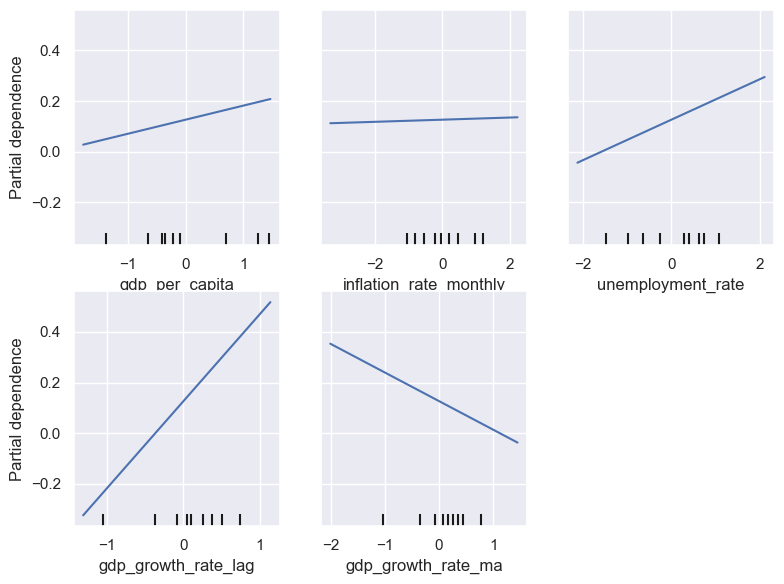

In [1114]:
compute_partial_dependence(best_model, estimator, X_train)

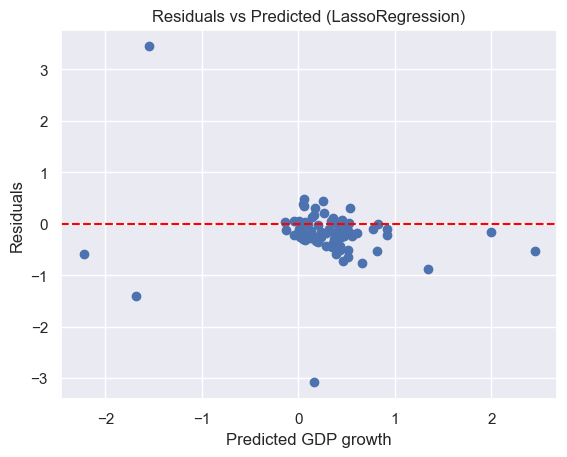

In [1115]:
y_pred, residuals_df = compute_residuals(predictions, y_test, best_name)

In [1116]:
residuals_df.tail()

,Residuals,Predicted,Actual
TIME_PERIOD,,,
2025-05-01,-0.116390,0.468609,0.352219
2025-06-01,-0.147288,0.509962,0.362674
2025-07-01,-0.202242,0.551957,0.349714
2025-08-01,-0.509436,0.509436,0.000000
2025-09-01,-0.231558,0.231558,0.000000


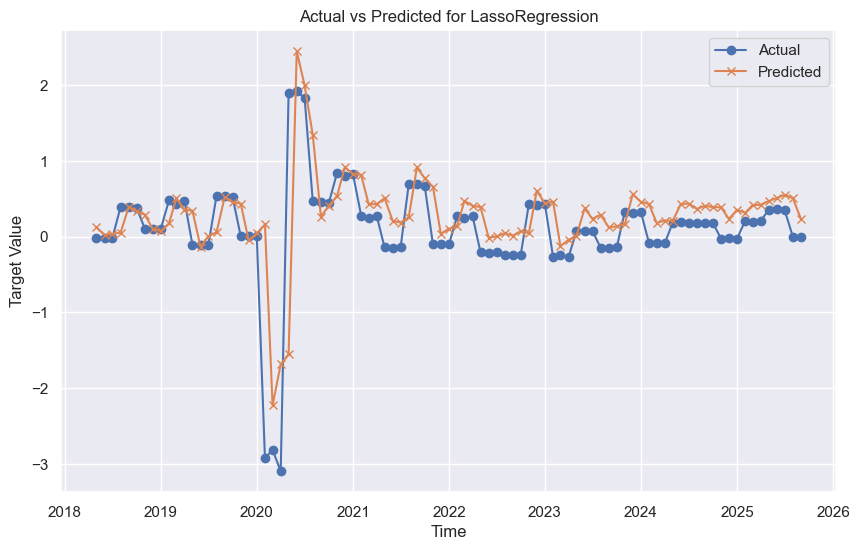

In [1117]:
compute_actual_predicted(y_test, y_pred, best_name)

### Model 2 (Inflation Rate)

In [1118]:
target_col = "inflation_rate"

In [1119]:
subset = train[
    [
        "gdp_per_capita",
        "inflation_rate_lag",
        "inflation_rate_monthly",
        "unemployment_rate",
        "gdp_growth_rate",
        "gdp_growth_rate_ma",
    ]
]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,2487.924978
1,gdp_per_capita,1.909036
2,inflation_rate_lag,1.780269
3,inflation_rate_monthly,1.028571
4,unemployment_rate,1.726417
5,gdp_growth_rate,1.719014
6,gdp_growth_rate_ma,1.753376


In [1120]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.drop(columns=[target_col])
y_test = test[target_col]

In [1121]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features)  # type: ignore
mi_scores[::].head(10)

inflation_rate_lag      1.002420
inflation_rate_ma       0.999695
total_population        0.897454
inflation_rate_ewm      0.890173
price_index             0.849899
education_attainment    0.849099
gas_emissions           0.805250
gdp_per_capita          0.789208
births                  0.779292
gdp                     0.727947
Name: MI Scores, dtype: float64

In [1122]:
drop_cols = [
    "deaths",
    "births",
    "net_migration",
    "household_income",
    "inflation_rate_ma",
    "inflation_rate_ewm",
    "unemployment_rate_ma",
    "gdp",
    # 'gdp_growth_rate',
    "gdp_growth_rate_lag",
    # 'gdp_growth_rate_ma',
    "gdp_growth_rate_ewm",
    # 'gdp_per_capita',
    "education_attainment",
    "price_index",
    "energy_prices",
    "gas_emissions",
    "total_population",
    "net_population_growth",
    "growth_rate",
    "adult_unemployment_rate",
    "youth_unemployment_rate",
    # 'inflation_rate_lag',
    "unemployment_rate_lag",
    # 'unemployment_rate',
    # 'inflation_rate_monthly'
]

In [1123]:
X_train = X_train.drop(
    columns=[col for col in drop_cols if col in X_train.columns]  # pyright: ignore
)
X_test = X_test.drop(
    columns=[col for col in drop_cols if col in X_test.columns]  # pyright: ignore
)

numerical_cols = list(X_train.select_dtypes("number").columns)
categorical_cols = list(X_train.select_dtypes("object").columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_per_capita', 'inflation_rate_monthly', 'unemployment_rate', 'gdp_growth_rate', 'gdp_growth_rate_ma', 'inflation_rate_lag']


In [1124]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(
#         key,
#         models_tuning[key],
#         value,
#         numerical_cols,
#         categorical_cols,
#         X_train,
#         y_train,
#         refit="rmse",
#     )

In [1125]:
# Best parameters
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(
        alpha=1.0, fit_intercept=True, solver="lsqr", random_state=RANDOM_STATE
    ),
    "LassoRegression": Lasso(
        alpha=0.01,
        fit_intercept=True,
        max_iter=5000,
        selection="random",
        random_state=RANDOM_STATE,
    ),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features="sqrt",
        random_state=RANDOM_STATE,
    ),
    "XGBoost": XGBRegressor(
        n_estimators=50,
        colsample_bytree=0.7,
        gamma=0,
        reg_alpha=0,
        reg_lambda=5,
        max_depth=3,
        learning_rate=0.2,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
    ),
}

In [1126]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.57542
Fold 2: 0.26275
Fold 3: 0.24957
Fold 4: 0.29334
Fold 5: 0.28381
Average neg_root_mean_squared_error: 0.33298

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.52940
Fold 2: 0.26853
Fold 3: 0.25074
Fold 4: 0.29487
Fold 5: 0.28967
Average neg_root_mean_squared_error: 0.32664

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.44421
Fold 2: 0.26518
Fold 3: 0.25334
Fold 4: 0.28484
Fold 5: 0.27575
Average neg_root_mean_squared_error: 0.30466

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 0.66108
Fold 2: 0.50881
Fold 3: 0.78944
Fold 4: 0.23972
Fold 5: 0.47985
Average neg_root_mean_squared_error: 0.53578

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 1.21668
Fold 2: 0.48028
Fold 3: 0.9269

In [1127]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.910205,0.942518,0.222909,0.486392,0.272909,0.650892
1,RidgeRegression,0.910132,0.938390,0.223124,0.504462,0.273019,0.673859
2,LassoRegression,0.909106,0.948063,0.222946,0.460945,0.274573,0.618702
3,RandomForestRegressor,0.985840,-0.117456,0.089939,1.684916,0.108373,2.869844
4,XGBoost,0.980575,-0.032340,0.101594,1.617591,0.126933,2.758382


In [1128]:
X_train_transformed = best_model.named_steps["preprocessor"].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         inflation_rate   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     211.2
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           6.45e-63
Time:                        12:17:11   Log-Likelihood:                -15.882
No. Observations:                 132   AIC:                             45.76
Df Residuals:                     125   BIC:                             65.94
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4106      0.024     57.789      0.0

In [1129]:
estimator = best_model.named_steps["model"]
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
5      inflation_rate_lag    0.822389
1  inflation_rate_monthly    0.112616
2       unemployment_rate    0.050932
4      gdp_growth_rate_ma    0.030882
0          gdp_per_capita    0.014890
3         gdp_growth_rate    0.004623


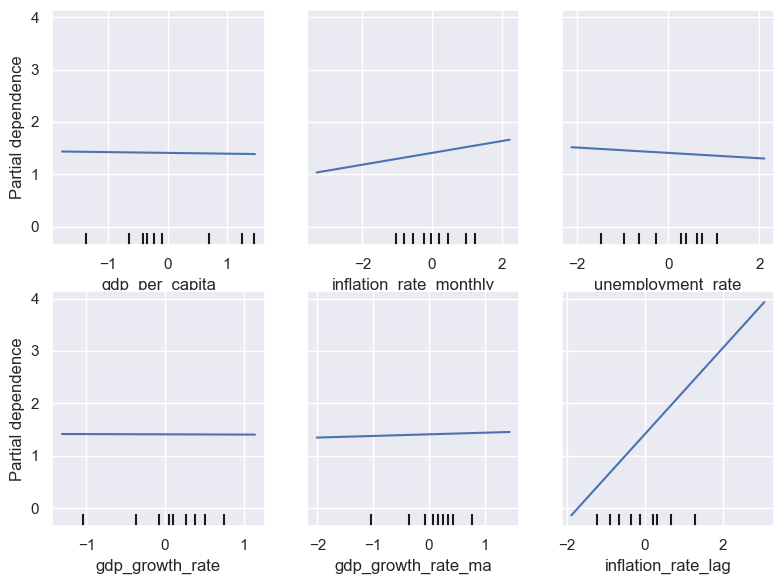

In [1130]:
compute_partial_dependence(best_model, estimator, X_train)

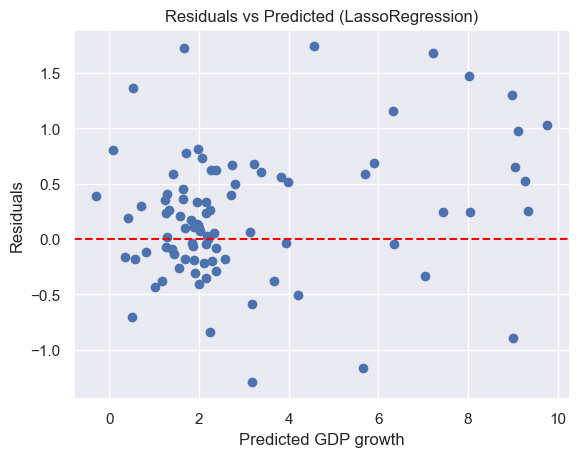

In [1131]:
y_pred, residuals_df = compute_residuals(predictions, y_test, best_name)

In [1132]:
residuals_df.tail()

,Residuals,Predicted,Actual
TIME_PERIOD,,,
2025-05-01,0.338787,1.961213,2.3
2025-06-01,0.622183,2.277817,2.9
2025-07-01,0.394966,2.705034,3.1
2025-08-01,0.670334,2.729666,3.4
2025-09-01,0.062258,3.137742,3.2


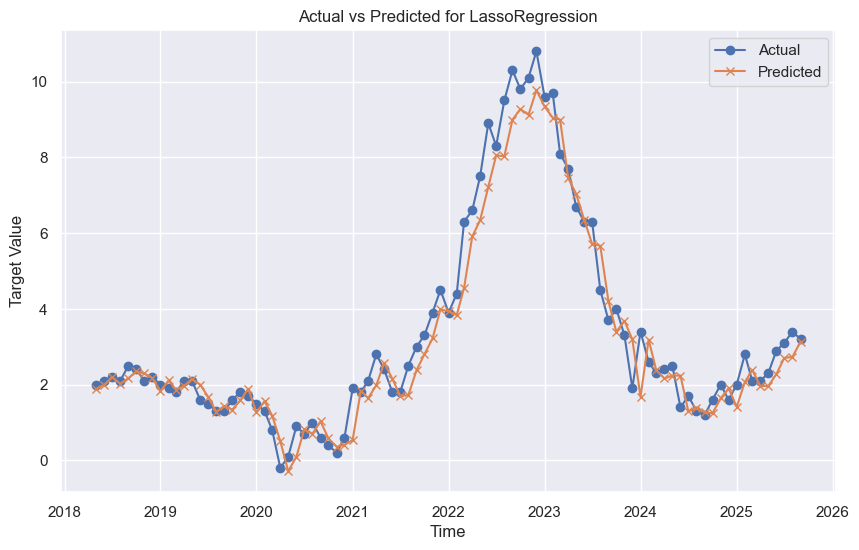

In [1133]:
compute_actual_predicted(y_test, y_pred, best_name)

### Model 3 (Unemployment Rate)

In [1134]:
target_col = "unemployment_rate"

In [1135]:
subset = train[
    [
        "total_population",
        "inflation_rate_monthly",
        "gdp_growth_rate",
        "gdp_growth_rate_ma",
        "unemployment_rate_ma",
    ]
]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,1348.293199
1,total_population,1.049729
2,inflation_rate_monthly,1.036703
3,gdp_growth_rate,1.634356
4,gdp_growth_rate_ma,1.665123
5,unemployment_rate_ma,1.312791


In [1136]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.drop(columns=[target_col])
y_test = test[target_col]

In [1137]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features)  # type: ignore
mi_scores[::].head(10)

adult_unemployment_rate    1.191566
unemployment_rate_ma       1.154618
total_population           1.129558
education_attainment       1.124306
price_index                1.080288
unemployment_rate_lag      1.029960
youth_unemployment_rate    1.018997
gas_emissions              0.964948
gdp                        0.934367
births                     0.905324
Name: MI Scores, dtype: float64

In [1138]:
drop_cols = [
    "deaths",
    "births",
    "net_migration",
    "household_income",
    "inflation_rate_ma",
    "inflation_rate_ewm",
    "unemployment_rate_ma",
    "gdp",
    # 'gdp_growth_rate',
    "gdp_growth_rate_lag",
    # 'gdp_growth_rate_ma',
    "gdp_growth_rate_ewm",
    "gdp_per_capita",
    "education_attainment",
    "price_index",
    "energy_prices",
    "inflation_rate_m",
    "gas_emissions",
    # 'total_population',
    "net_population_growth",
    "growth_rate",
    "adult_unemployment_rate",
    "youth_unemployment_rate",
    "inflation_rate_lag",
    # 'unemployment_rate_lag',
    "gdp_growth_rate_lag",
    "inflation_rate",
    # 'inflation_rate_monthly'
]

In [1139]:
X_train = X_train.drop(
    columns=[col for col in drop_cols if col in X_train.columns]  # type: ignore
)
X_test = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])  # type: ignore

numerical_cols = list(X_train.select_dtypes("number").columns)
categorical_cols = list(X_train.select_dtypes("object").columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['inflation_rate_monthly', 'total_population', 'gdp_growth_rate', 'gdp_growth_rate_ma', 'unemployment_rate_lag']


In [1140]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(
#         key,
#         models_tuning[key],
#         value,
#         numerical_cols,
#         categorical_cols,
#         X_train,
#         y_train,
#         refit="rmse",
#     )

In [1141]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=True),
    "RidgeRegression": Ridge(
        alpha=1.0, fit_intercept=True, solver="svd", random_state=RANDOM_STATE
    ),
    "LassoRegression": Lasso(
        alpha=0.01,
        fit_intercept=True,
        max_iter=10000,
        selection="random",
        random_state=RANDOM_STATE,
    ),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features="sqrt",
        random_state=RANDOM_STATE,
    ),
    "XGBoost": XGBRegressor(
        n_estimators=50,
        colsample_bytree=0.7,
        gamma=0,
        reg_alpha=0,
        reg_lambda=1,
        max_depth=7,
        learning_rate=0.2,
        min_child_weight=5,
        subsample=0.7,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
    ),
}

In [1142]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 1.45257
Fold 2: 0.74011
Fold 3: 0.20906
Fold 4: 0.32721
Fold 5: 0.31551
Average neg_root_mean_squared_error: 0.60889

--- Training RidgeRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.09107
Fold 2: 0.79315
Fold 3: 0.22234
Fold 4: 0.32489
Fold 5: 0.31606
Average neg_root_mean_squared_error: 0.74950

--- Training LassoRegression ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 1.99153
Fold 2: 0.67561
Fold 3: 0.19949
Fold 4: 0.30602
Fold 5: 0.31556
Average neg_root_mean_squared_error: 0.69764

--- Training RandomForestRegressor ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.38821
Fold 2: 0.62645
Fold 3: 0.23867
Fold 4: 0.48465
Fold 5: 0.42418
Average neg_root_mean_squared_error: 0.83243

--- Training XGBoost ---

Cross-validation results (neg_root_mean_squared_error):
Fold 1: 2.26432
Fold 2: 0.79613
Fold 3: 0.3055

In [1143]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.884314,0.714508,0.230068,0.369909,0.297022,0.485565
1,RidgeRegression,0.888743,0.702496,0.227064,0.376437,0.291281,0.495674
2,LassoRegression,0.887704,0.717211,0.227966,0.367899,0.292639,0.483261
3,RandomForestRegressor,0.986809,0.329422,0.074409,0.634292,0.100299,0.744174
4,XGBoost,0.994678,-0.023372,0.045433,0.780987,0.063710,0.919320


In [1144]:
X_train_transformed = best_model.named_steps["preprocessor"].transform(X_train)
X_train_transformed = sm.add_constant(X_train_transformed)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     201.4
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           2.60e-58
Time:                        12:17:14   Log-Likelihood:                -24.443
No. Observations:                 132   AIC:                             60.89
Df Residuals:                     126   BIC:                             78.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5568      0.026    291.301      0.0

In [1145]:
estimator = best_model.named_steps["model"]
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                  Feature  Importance
4   unemployment_rate_lag    0.818118
3      gdp_growth_rate_ma    0.042408
2         gdp_growth_rate    0.028206
0  inflation_rate_monthly    0.020823
1        total_population    0.006284


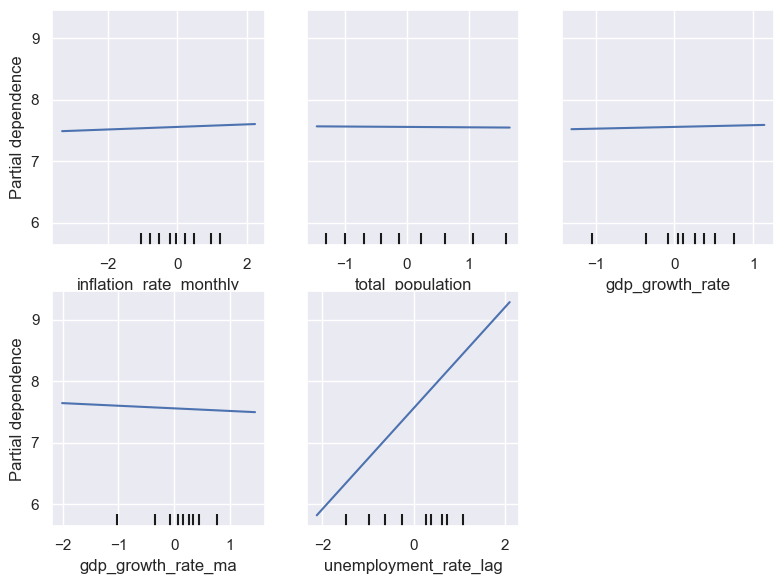

In [1146]:
compute_partial_dependence(best_model, estimator, X_train)

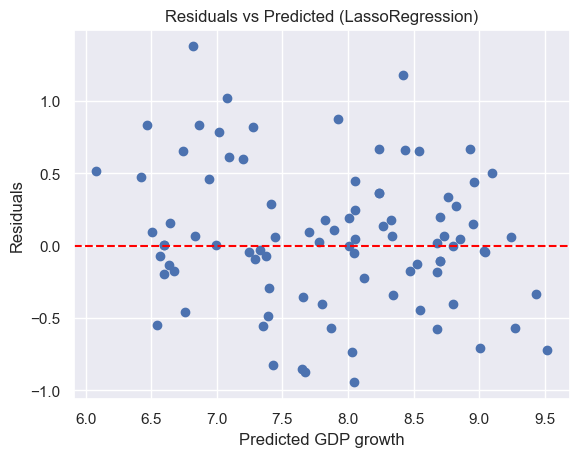

In [1147]:
y_pred, residuals_df = compute_residuals(predictions, y_test, best_name)

In [1148]:
residuals_df.tail()

,Residuals,Predicted,Actual
TIME_PERIOD,,,
2025-05-01,0.664549,8.435451,9.1
2025-06-01,-0.707707,9.007707,8.3
2025-07-01,0.664947,8.235053,8.9
2025-08-01,0.066329,8.733671,8.8
2025-09-01,0.019054,8.680946,8.7


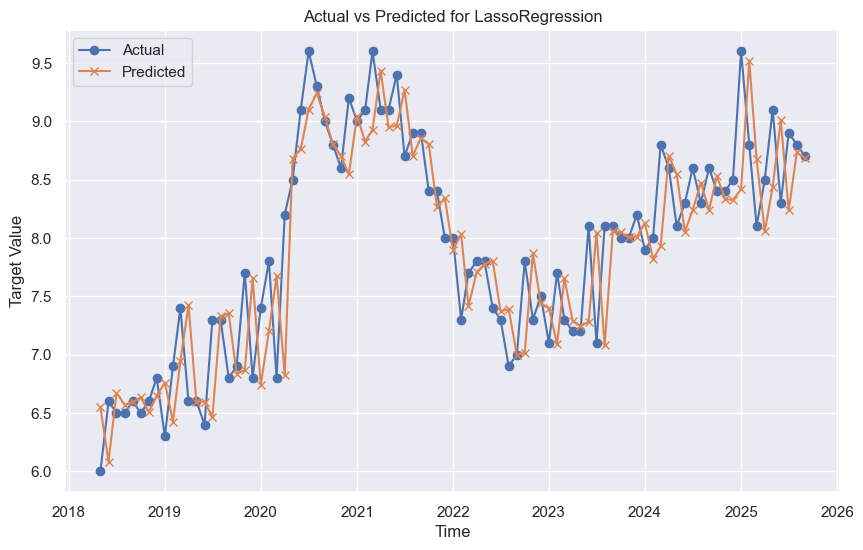

In [1149]:
compute_actual_predicted(y_test, y_pred, best_name)